# K-Means
This notebook applies K-Means clustering to the two datasets contained in `../final/`. All of them contains information about the GDP and the CO2 emissions for each country, however, they are divided as:
- Every country (with time series) 
- European countries

## Step 0: Import and Read Data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
os.makedirs('../plots/kmeans/elbow', exist_ok=True)

In [14]:
df = pd.read_csv('../data/final/gdp_co2_emissions.csv')
df.drop(columns=['Country Code', 'CO2 emissions', 'GDP growth (annual %)', 'GDP'], inplace=True)
df.head()

,Country Name,Continent,Year,CO2 emissions per capita,GDP per capita,log (GDP pc),log (CO2 pc)
0,Afghanistan,Asia,2000,0.052017,1617.826475,7.388839,-2.956177
1,Afghanistan,Asia,2001,0.052706,1454.110782,7.282150,-2.943032
2,Afghanistan,Asia,2002,0.062731,1774.308743,7.481166,-2.768904
3,Afghanistan,Asia,2003,0.068608,1815.928200,7.504352,-2.679340
4,Afghanistan,Asia,2004,0.052513,1776.918207,7.482636,-2.946689


 ---
## 1. Apply K-Means

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

num_ranges = 3
min_year = df['Year'].min()
max_year = df['Year'].max()
print(f"Data covers years from {min_year} to {max_year}")


Data covers years from 1990 to 2024


In [16]:
def elbow_method(df, cols, max_clusters=10):
    X = df[cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
        
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)
    return wcss

In [17]:
def kmeans_cluster(df, cols, n_clusters=3, results_col_name='Cluster'):
    cluster_assignments = []
    cluster_statistics = []

    X = df[cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
        
    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=23)
    cluster_assignments = kmeans.fit_predict(X_scaled)
    
    # Remap clusters based on x centroid coordinate
    centroids_scaled = kmeans.cluster_centers_
    sorted_indices = np.argsort(centroids_scaled[:, 0]) # first feature (GDP per capita)

    mapping = {old: new for new, old in enumerate(sorted_indices)}
    ordered_cluster_assignments = np.array([mapping[c] for c in cluster_assignments])
    ordered_centroids_scaled = centroids_scaled[sorted_indices]

    centroids_real = scaler.inverse_transform(ordered_centroids_scaled)

    cluster_statistics.append({
        'Num Cluster': range(n_clusters),
        'Count': np.bincount(ordered_cluster_assignments),
        'Centroids': centroids_real
    })
    
    df[results_col_name] = ordered_cluster_assignments.astype(int)
    return df, cluster_statistics

### 1.1 Elbow Method

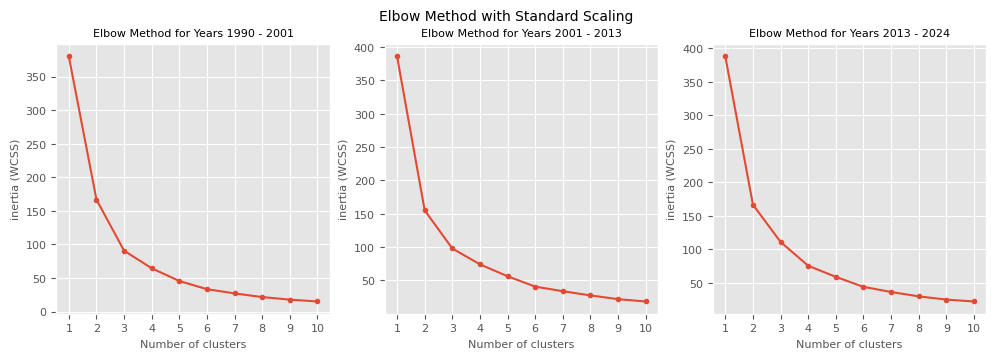

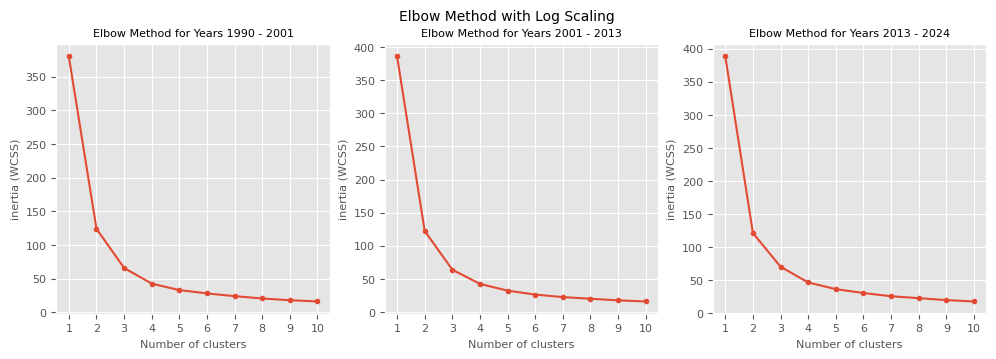

In [18]:
fig_std, axes_std = plt.subplots(1, num_ranges, figsize=(4 * num_ranges, 3.5))
fig_log, axes_log = plt.subplots(1, num_ranges, figsize=(4 * num_ranges, 3.5))

for i in range(num_ranges):
    # create subsets
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    df_subset = df[(df['Year'] >= year_start) & (df['Year'] < year_end)]
    df_subset = df_subset.groupby('Country Name').agg({
            'GDP per capita': 'mean', 
            'CO2 emissions per capita': 'mean',
            'log (GDP pc)': 'mean',
            'log (CO2 pc)': 'mean'
        }).reset_index()
    
    # Elbow method standard scale
    wcss = elbow_method(df_subset, ['GDP per capita', 'CO2 emissions per capita'])
    axes_std[i].plot(range(1, len(wcss) + 1), wcss, marker='o', markersize=3)
    axes_std[i].set_title(f'Elbow Method for Years {year_start:.0f} - {year_end:.0f}', fontsize=8)
    axes_std[i].set_xlabel('Number of clusters', fontsize=8)
    axes_std[i].set_ylabel('inertia (WCSS)', fontsize=8)
    axes_std[i].set_xticks(range(1, len(wcss) + 1))
    axes_std[i].tick_params(axis='x', labelsize=8)
    axes_std[i].tick_params(axis='y', labelsize=8)

    # Elbow method log scale
    wcss_log = elbow_method(df_subset, ['log (GDP pc)', 'log (CO2 pc)'])
    axes_log[i].plot(range(1, len(wcss_log) + 1), wcss_log, marker='o', markersize=3)
    axes_log[i].set_title(f'Elbow Method for Years {year_start:.0f} - {year_end:.0f}', fontsize=8)
    axes_log[i].set_xlabel('Number of clusters', fontsize=8)
    axes_log[i].set_ylabel('inertia (WCSS)', fontsize=8)
    axes_log[i].set_xticks(range(1, len(wcss_log) + 1))
    axes_log[i].tick_params(axis='x', labelsize=8)
    axes_log[i].tick_params(axis='y', labelsize=8)

fig_std.suptitle('Elbow Method with Standard Scaling', fontsize=10)
fig_log.suptitle('Elbow Method with Log Scaling', fontsize=10)
fig_std.savefig(f'../plots/kmeans/elbow/elbow_std.png')
fig_log.savefig(f'../plots/kmeans/elbow/elbow_log.png')

### Optimal number of clusters (k)
Across almost all time periods, for both standard and log scaling, the **elbow** (point of inflection, where adding more clusters doesn't significantly decreases the Inertia anymore) is visible at k=3 or k=4.
Specifically, k=2 would over simplify the world in only two groups (Low and High emitters/economies); whereas **k=3 is the right trade-off** for most of the periods, separating countries in three groups:
- low GDP, low CO2 emissions (developing nations)
- mid GDP, mid CO2 emissions (emerging and industrializing nations)
- high GDP, high CO2 emissions (developed and industrialized nations) 

Nontheless, in recent period (2013-2024), the **elbow** is slightly more evident in k=4, suggesting that the global landscape is becoming more frammenting, possibly due to green politics of some developed countries.

However, despite small changes in the last decade, the shape of the curves is almost consistent across the three decades, demonstrating that the global structure of wealth and carbon emissions hasn't faced a radical change yet.

---
### Standard vs Log scaling
The *standard* scaling produced "softer" elbows beacuse of the high skewness of the data (few richest/high emitter countries are extreme outliers), which means higher inertia for the same k, with respect to the *log scaling*. 

This can be explained by the transformations applied. In the first case, only the Standard Scaler has been used (linear transformation), which stretches points on the plane withouth changing relative position from one another, therefore further points will remain further, resulting in **high inertia**. In the second case, additionally to the Standard scaling, also a Logaritmic transformation has been used (non linear transformation), changing relative distances into absolute distances (1 and 100 will have same distance as 100 and 1000): this produces more dense regions with **lower inertia**.

### 1.2 K-Means on different time ranges

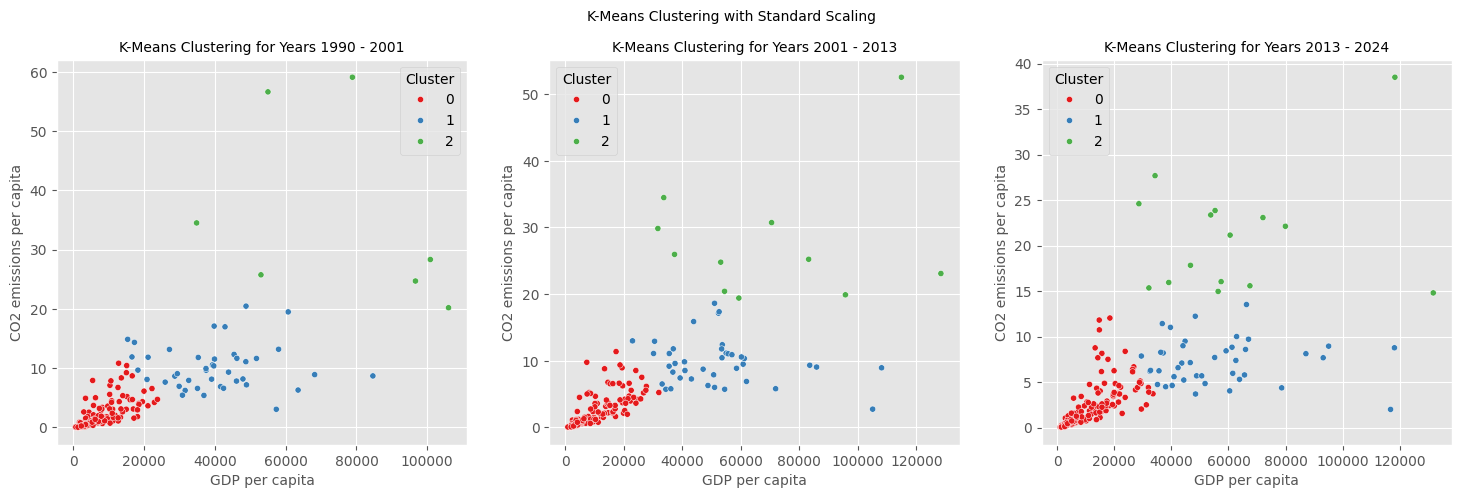

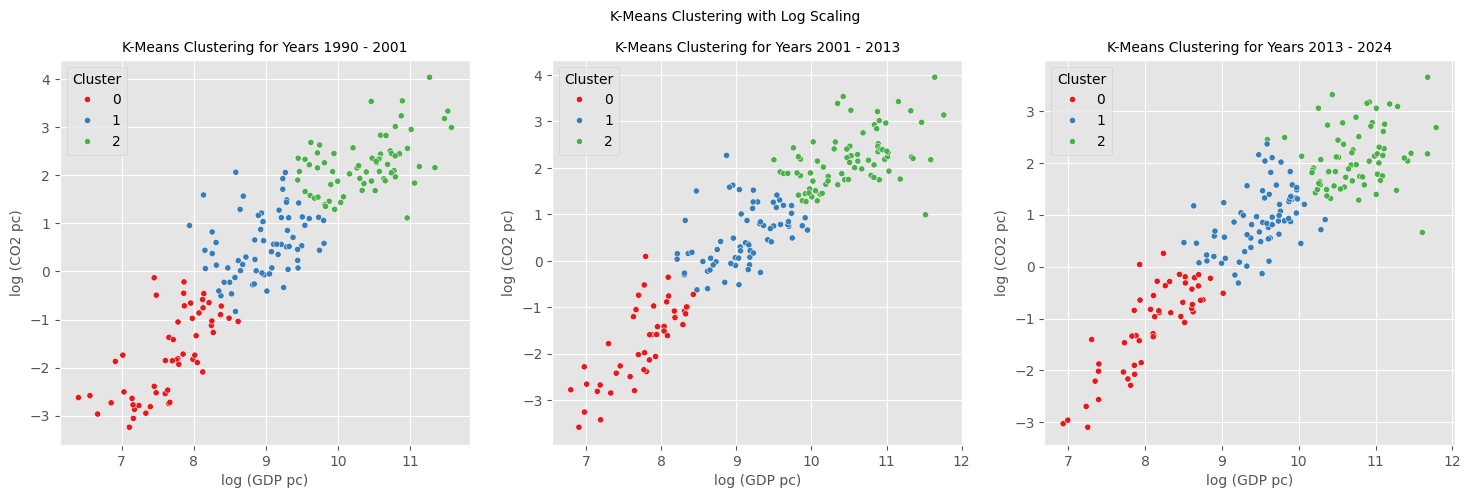

In [19]:
fig_std, axes_std = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))
fig_log, axes_log = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))

stats_std_all = {}
stats_log_all = {}
df['Cluster (Std)'] = np.nan
df['Cluster (Log)'] = np.nan

for i in range(num_ranges):
    # create subsets
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    df_subset = df[(df['Year'] >= year_start) & (df['Year'] < year_end)]
    df_subset_agg = df_subset.groupby('Country Name').agg({
            'GDP per capita': 'mean', 
            'CO2 emissions per capita': 'mean',
            'log (GDP pc)': 'mean',
            'log (CO2 pc)': 'mean'
        }).reset_index()
    period_label = f"{int(year_start)}-{int(year_end)}"
    
    # ------------------------------ K-Means standard scale ------------------------------------
    df_cluster_std, stats_std = kmeans_cluster(df_subset_agg, ['GDP per capita', 'CO2 emissions per capita'], 
                                               n_clusters=3, results_col_name='Cluster (Std)') 
    stats_std_all[period_label] = stats_std[0] if isinstance(stats_std, list) else stats_std

    sns.scatterplot(data=df_cluster_std, x='GDP per capita', y='CO2 emissions per capita', s=20, 
                       hue='Cluster (Std)', palette='Set1', ax=axes_std[i], legend='brief')
    axes_std[i].set_title(f'K-Means Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_std[i].set_xlabel('GDP per capita', fontsize=10)
    axes_std[i].set_ylabel('CO2 emissions per capita', fontsize=10)
    axes_std[i].get_legend().set_title('Cluster')
    
    mask = (df['Year'] >= year_start) & (df['Year'] <= year_end)
    cluster_map_std = df_cluster_std.set_index('Country Name')['Cluster (Std)']
    df.loc[mask, 'Cluster (Std)'] = df.loc[mask, 'Country Name'].map(cluster_map_std)

    # -------------------------------- K-Means log scale ------------------------------------
    df_cluster_log, stats_log = kmeans_cluster(df_subset_agg, ['log (GDP pc)', 'log (CO2 pc)'], 
                                               n_clusters=3, results_col_name='Cluster (Log)') 
    stats_log_all[period_label] = stats_log[0] if isinstance(stats_log, list) else stats_log

    sns.scatterplot(data=df_cluster_log, x='log (GDP pc)', y='log (CO2 pc)', s=20, 
                       hue='Cluster (Log)', palette='Set1', ax=axes_log[i], legend='brief')
    axes_log[i].set_title(f'K-Means Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
    axes_log[i].set_xlabel('log (GDP pc)', fontsize=10)
    axes_log[i].set_ylabel('log (CO2 pc)', fontsize=10)
    axes_log[i].get_legend().set_title('Cluster')
    
    cluster_map_log = df_cluster_log.set_index('Country Name')['Cluster (Log)']
    df.loc[mask, 'Cluster (Log)'] = df.loc[mask, 'Country Name'].map(cluster_map_log)
    
fig_std.suptitle('K-Means Clustering with Standard Scaling', fontsize=10)
fig_log.suptitle('K-Means Clustering with Log Scaling', fontsize=10)
fig_std.savefig(f'../plots/kmeans/cluster_std.png')
fig_log.savefig(f'../plots/kmeans/cluster_log.png')

The log-scaling prevents the K-Means algorithm from being dominated by a few wealthy "outlier" nations, allowing it to see more clearly the patterns in the developing nations. Indeed, in the standard scaling graph, K-Means is not able to differentiate between low individual wealth countries and medium ones due to the extreme individually wealthy nations, which "compress" the other ones at the origin. 

### 1.3 Cluster Inspection

In [20]:
import pandas as pd

for i in range(num_ranges):
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    period_label = f"{int(year_start)}-{int(year_end)}"
    
    data = stats_std_all[period_label]
    
    print(f"\n{'='*70}")
    print(f"Cluster distribution for years: {period_label}")
    print(f"{'='*70}")

    table_data = []
    for c in data['Num Cluster']:
        table_data.append({
            'Cluster': c,
            'Countries': data['Count'][c],
            'Centroid GDP pc (std)': f"{data['Centroids'][c][0]:.0f}",
            'Centroid CO2 pc (std)': f"{data['Centroids'][c][1]:.2f}"
        })
    
    df_table = pd.DataFrame(table_data)
    
    print(df_table.to_string(index=False, justify='center', col_space=15))
    print(f"{'='*70}\n")


Cluster distribution for years: 1990-2001
     Cluster        Countries   Centroid GDP pc (std) Centroid CO2 pc (std)
       0              141                7419                  2.01        
       1               42               39813                 10.17        
       2                7               75035                 35.61        


Cluster distribution for years: 2001-2012
     Cluster        Countries   Centroid GDP pc (std) Centroid CO2 pc (std)
       0              142                9946                  2.27        
       1               40               51757                  9.79        
       2               11               69275                 27.85        


Cluster distribution for years: 2012-2024
     Cluster        Countries   Centroid GDP pc (std) Centroid CO2 pc (std)
       0              138               11648                  2.33        
       1               41               55835                  7.24        
       2               15        

In [21]:
import pandas as pd

for i in range(num_ranges):
    year_start = min_year + i * (max_year - min_year) / num_ranges
    year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
    period_label = f"{int(year_start)}-{int(year_end)}"
    
    data = stats_log_all[period_label]
    
    print(f"\n{'='*70}")
    print(f"Cluster distribution for years: {period_label}")
    print(f"{'='*70}")

    table_data = []
    for c in data['Num Cluster']:
        table_data.append({
            'Cluster': c,
            'Countries': data['Count'][c],
            'Centroid GDP pc (log)': f"{data['Centroids'][c][0]:.2f}",
            'Centroid CO2 pc (log)': f"{data['Centroids'][c][1]:.2f}"
        })
    
    df_table = pd.DataFrame(table_data)
    
    print(df_table.to_string(index=False, justify='center', col_space=15))
    print(f"{'='*70}\n")


Cluster distribution for years: 1990-2001
     Cluster        Countries   Centroid GDP pc (log) Centroid CO2 pc (log)
       0               54                7.67                 -1.73        
       1               69                8.96                  0.56        
       2               67               10.37                  2.24        


Cluster distribution for years: 2001-2012
     Cluster        Countries   Centroid GDP pc (log) Centroid CO2 pc (log)
       0               45                7.76                 -1.73        
       1               69                9.11                  0.52        
       2               79               10.53                  2.19        


Cluster distribution for years: 2012-2024
     Cluster        Countries   Centroid GDP pc (log) Centroid CO2 pc (log)
       0               53                8.08                 -1.15        
       1               71                9.51                  0.90        
       2               70        

**Findings**
- As previously noticed in the Elbow Method, Standard scaling is heavily influenced by outliers. This resulted in one massive cluster of 130+ countries and two tiny clusters for outliers. 
Log transformation instead, provides a much more balanced distribution, revealing a clearer linear correlation between wealth and emissions across all development stages.

- Across all periods, we see a consistent positive correlation beteen individual wealth and CO2 emissions

- In the most recent period, we observe a slight "decoupling" in Cluster 2. This term is utilized for an economy that is able to grow without corresponding increases in environmental pressure. 
In fact, in the table above, we can see that while GDP continues to rise, the CO2 centroids have actually decreased compared to the 1990s (from a log of 2.24 to 2.11). This suggests that the wealthiest nations are beginning to improve energy efficiency and are transitioninig to renewables.

## 2. Continents Analysis

In [22]:
def elbow_method_continent(continent_name):
    df_continent = df[df['Continent'] == continent_name]
    fig_log, axes_log = plt.subplots(1, num_ranges, figsize=(4 * num_ranges, 3.5))

    for i in range(num_ranges):
        # create subsets
        year_start = min_year + i * (max_year - min_year) / num_ranges
        year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
        df_subset = df_continent[(df_continent['Year'] >= year_start) & (df_continent['Year'] < year_end)]
        df_subset = df_subset.groupby('Country Name').agg({
                'GDP per capita': 'mean', 
                'CO2 emissions per capita': 'mean',
                'log (GDP pc)': 'mean',
                'log (CO2 pc)': 'mean'
            }).reset_index()

        # Elbow method log scale
        wcss_log = elbow_method(df_subset, ['log (GDP pc)', 'log (CO2 pc)'])
        axes_log[i].plot(range(1, len(wcss_log) + 1), wcss_log, marker='o', markersize=3)
        axes_log[i].set_title(f'Elbow Method for Years {year_start:.0f} - {year_end:.0f}', fontsize=8)
        axes_log[i].set_xlabel('Number of clusters', fontsize=8)
        axes_log[i].set_ylabel('inertia (WCSS)', fontsize=8)
        axes_log[i].set_xticks(range(1, len(wcss_log) + 1))
        axes_log[i].tick_params(axis='x', labelsize=8)
        axes_log[i].tick_params(axis='y', labelsize=8)

    fig_std.suptitle(f'Elbow Method with Standard Scaling ({continent_name})', fontsize=10)
    fig_log.suptitle(f'Elbow Method with Log Scaling ({continent_name})', fontsize=10)
    fig_std.savefig(f'../plots/kmeans/elbow/elbow_std_{continent_name.lower()}.png')
    fig_log.savefig(f'../plots/kmeans/elbow/elbow_log_{continent_name.lower()}.png')

In [38]:
def kmeans_cluster_continent(continent_name, num_clusters=3):
    fig_std, axes_std = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))
    fig_log, axes_log = plt.subplots(1, num_ranges, figsize=(6 * num_ranges, 5))

    stats_std_all_continent = {}
    stats_log_all_continent = {}
    df_continent = df[df['Continent'] == continent_name]
    df_continent['Cluster (Std)'] = np.nan
    df_continent['Cluster (Log)'] = np.nan

    for i in range(num_ranges):
        # create subsets
        year_start = min_year + i * (max_year - min_year) / num_ranges
        year_end = min_year + (i + 1) * (max_year - min_year) / num_ranges
        df_subset = df_continent[(df_continent['Year'] >= year_start) & (df_continent['Year'] < year_end)]
        df_subset_agg = df_subset.groupby('Country Name').agg({
                'GDP per capita': 'mean', 
                'CO2 emissions per capita': 'mean',
                'log (GDP pc)': 'mean',
                'log (CO2 pc)': 'mean'
            }).reset_index()
        period_label = f"{int(year_start)}-{int(year_end)}"
        
        # ------------------------------ K-Means standard scale ------------------------------------
        df_cluster_std, stats_std = kmeans_cluster(df_subset_agg, ['GDP per capita', 'CO2 emissions per capita'], 
                                                n_clusters=num_clusters, results_col_name='Cluster (Std)') 
        stats_std_all_continent[period_label] = stats_std[0] if isinstance(stats_std, list) else stats_std

        sns.scatterplot(data=df_cluster_std, x='GDP per capita', y='CO2 emissions per capita', s=20, 
                        hue='Cluster (Std)', palette='Set1', ax=axes_std[i], legend='brief')
        axes_std[i].set_title(f'K-Means Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
        axes_std[i].set_xlabel('GDP per capita', fontsize=10)
        axes_std[i].set_ylabel('CO2 emissions per capita', fontsize=10)
        axes_std[i].get_legend().set_title('Cluster')
        for line in range(0, df_cluster_std.shape[0]):
            axes_std[i].text(df_cluster_std['GDP per capita'][line], 
                            df_cluster_std['CO2 emissions per capita'][line] + 0.5, 
                            df_cluster_std['Country Name'][line], 
                            horizontalalignment='center', color='black', alpha=0.4, fontsize=7)
        
        mask = (df_continent['Year'] >= year_start) & (df_continent['Year'] <= year_end)
        cluster_map_std = df_cluster_std.set_index('Country Name')['Cluster (Std)']
        df_continent.loc[mask, 'Cluster (Std)'] = df_continent.loc[mask, 'Country Name'].map(cluster_map_std)

        # -------------------------------- K-Means log scale ------------------------------------
        df_cluster_log, stats_log = kmeans_cluster(df_subset_agg, ['log (GDP pc)', 'log (CO2 pc)'], 
                                                n_clusters=num_clusters, results_col_name='Cluster (Log)') 
        stats_log_all_continent[period_label] = stats_log[0] if isinstance(stats_log, list) else stats_log

        sns.scatterplot(data=df_cluster_log, x='log (GDP pc)', y='log (CO2 pc)', s=20, 
                        hue='Cluster (Log)', palette='Set1', ax=axes_log[i], legend='brief')
        axes_log[i].set_title(f'K-Means Clustering for Years {year_start:.0f} - {year_end:.0f}', fontsize=10)
        axes_log[i].set_xlabel('log (GDP pc)', fontsize=10)
        axes_log[i].set_ylabel('log (CO2 pc)', fontsize=10)
        axes_log[i].get_legend().set_title('Cluster')
        for line in range(0, df_cluster_log.shape[0]):
            axes_log[i].text(df_cluster_log['log (GDP pc)'][line], 
                            df_cluster_log['log (CO2 pc)'][line] + 0.07, 
                            df_cluster_log['Country Name'][line], 
                            horizontalalignment='center', color='black', alpha=0.4, fontsize=7)
        
        cluster_map_log = df_cluster_log.set_index('Country Name')['Cluster (Log)']
        df_continent.loc[mask, 'Cluster (Log)'] = df_continent.loc[mask, 'Country Name'].map(cluster_map_log)
        
    fig_std.suptitle(f'K-Means Clustering with Standard Scaling ({continent_name})', fontsize=10)
    fig_log.suptitle(f'K-Means Clustering with Log Scaling ({continent_name})', fontsize=10)
    fig_std.savefig(f'../plots/kmeans/cluster_std_{continent_name.lower()}.png')
    fig_log.savefig(f'../plots/kmeans/cluster_log_{continent_name.lower()}.png')

## 2.1 Europe

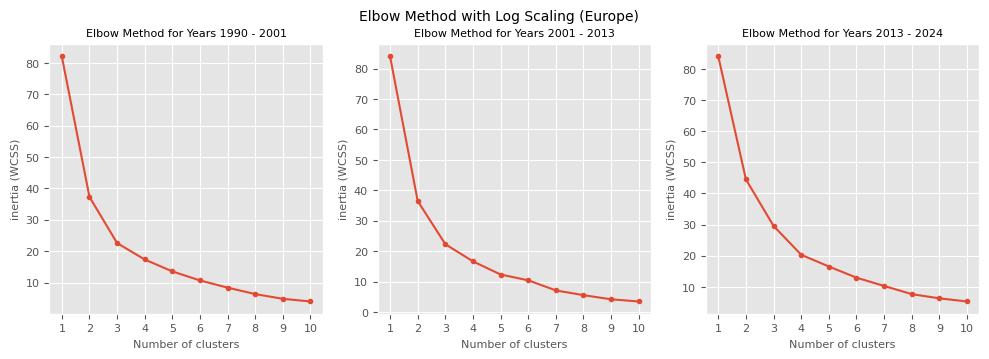

In [24]:
elbow_method_continent('Europe')

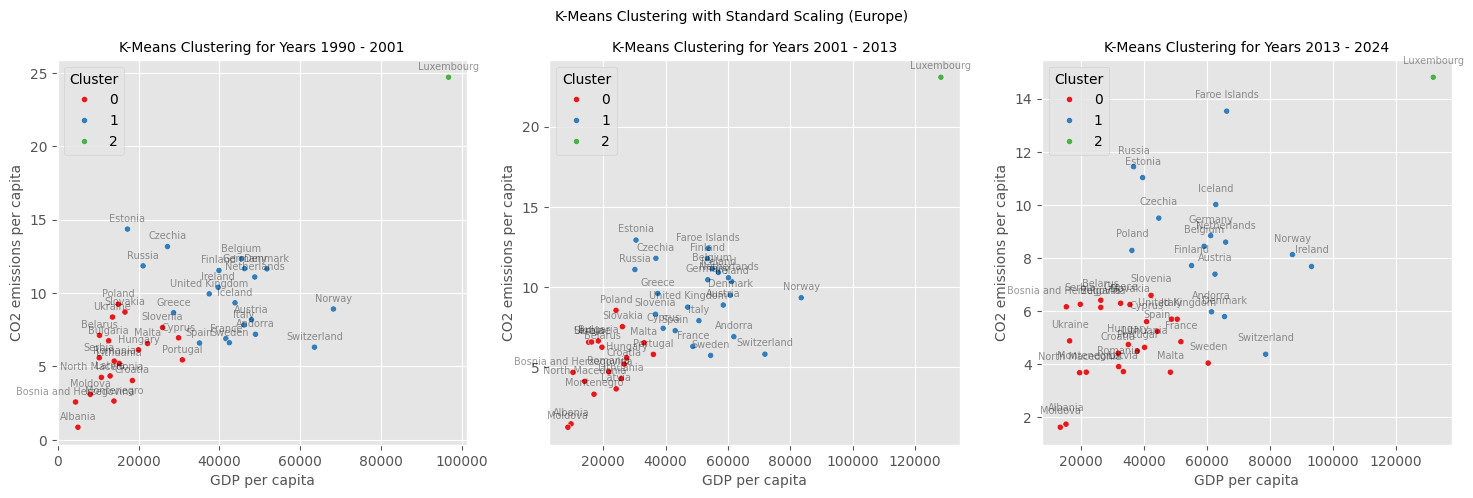

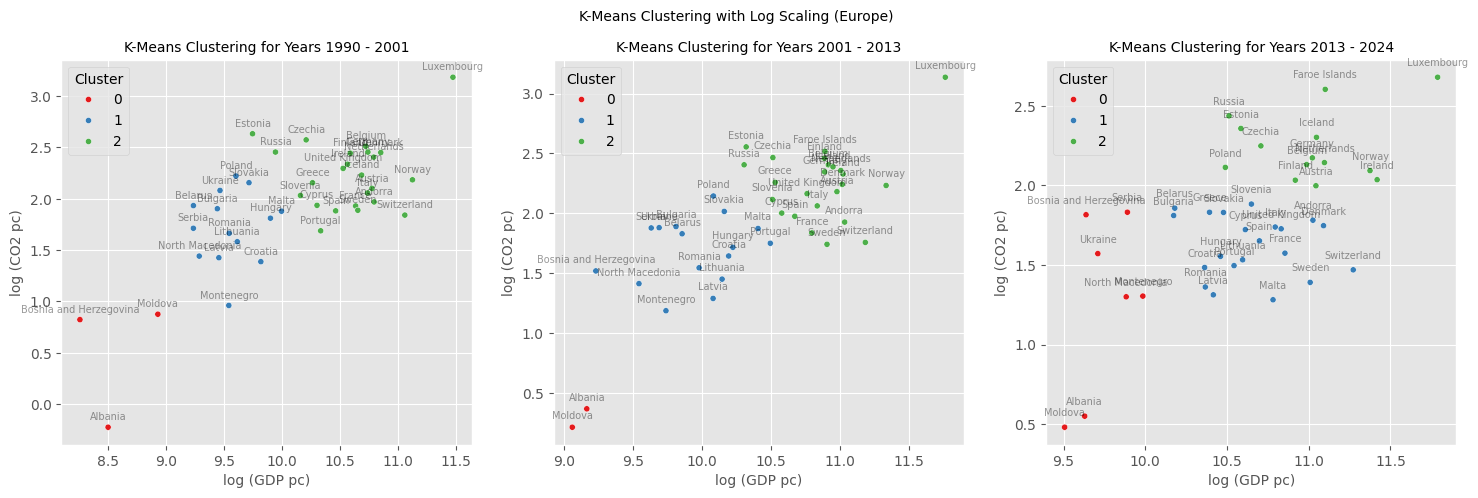

In [39]:
kmeans_cluster_continent('Europe', num_clusters=3)

**Findings**
- In the Standard Scaling plots, Luxembourg remains a persistent outlier, creating itself, alone, Cluster 2 (green) due to its extremely high GDP per capita and CO2 emissions compared to the other european nations. This causes to group the rest of Europe together in two close clusters (0 and 1).

- The Log Scaling plots reveal a more delicate transition between clusters.

    - Cluster 0 (Red): Contains developing or post-Soviet economies like Albania, Moldova, and Bosnia and Herzegovina.

    - Cluster 1 (Blue): Contains mainly Central and Eastern European nations moving toward higher wealth.

    - Cluster 2 (Green): Contains Western and Nordic nations.

The *Log-scaling* plots show more scattered data with respect to the linear regression previously observed among all countries in the World. This highlights more difference between carbon efficiency in Europe, compared to the global average.
While the global data suggests a rigid relation between wealth and emissions, the European subset presents more variance on both axis. 

This spread demonstrates that countries with similar economy, such as Sweden, Austria or Iceland (2024), could have vastly different carbon footprints, due to their specific sustainability policies, reliance on renewables.
In the most recent period, we see Cluster 1 (blue) shifting right, despite maintaing its position on the log(CO2 per capita) axes, indicating both economic growth yet constant carbon footprint.

## Asia

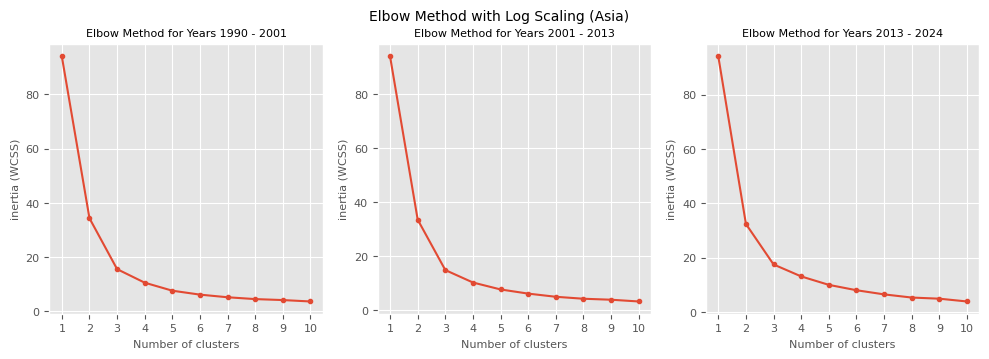

In [41]:
elbow_method_continent('Asia')

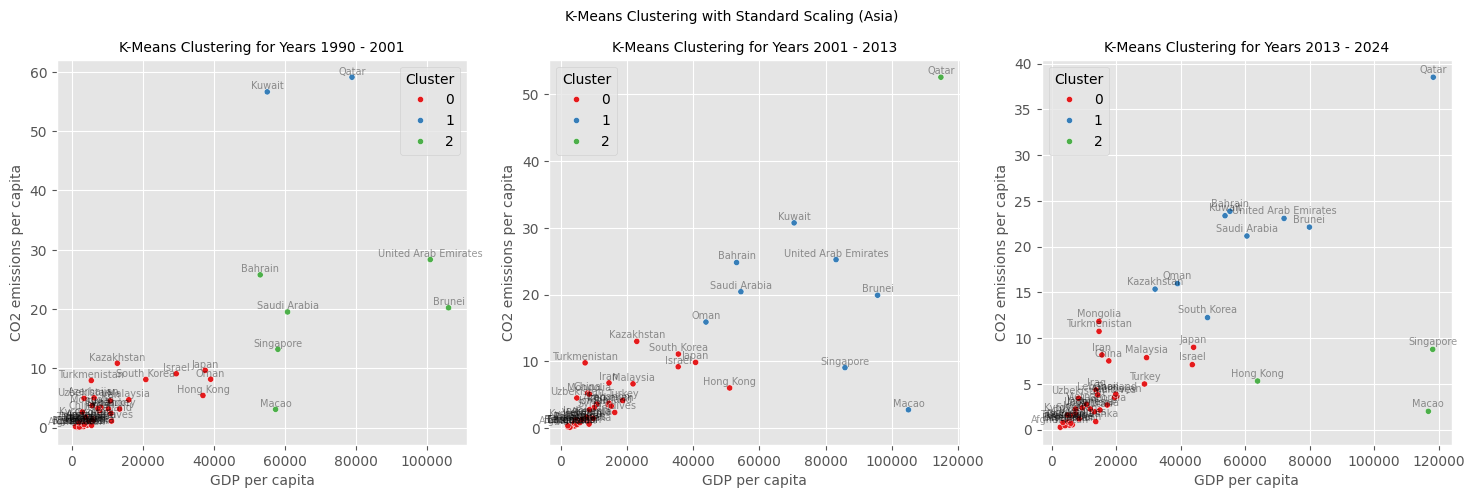

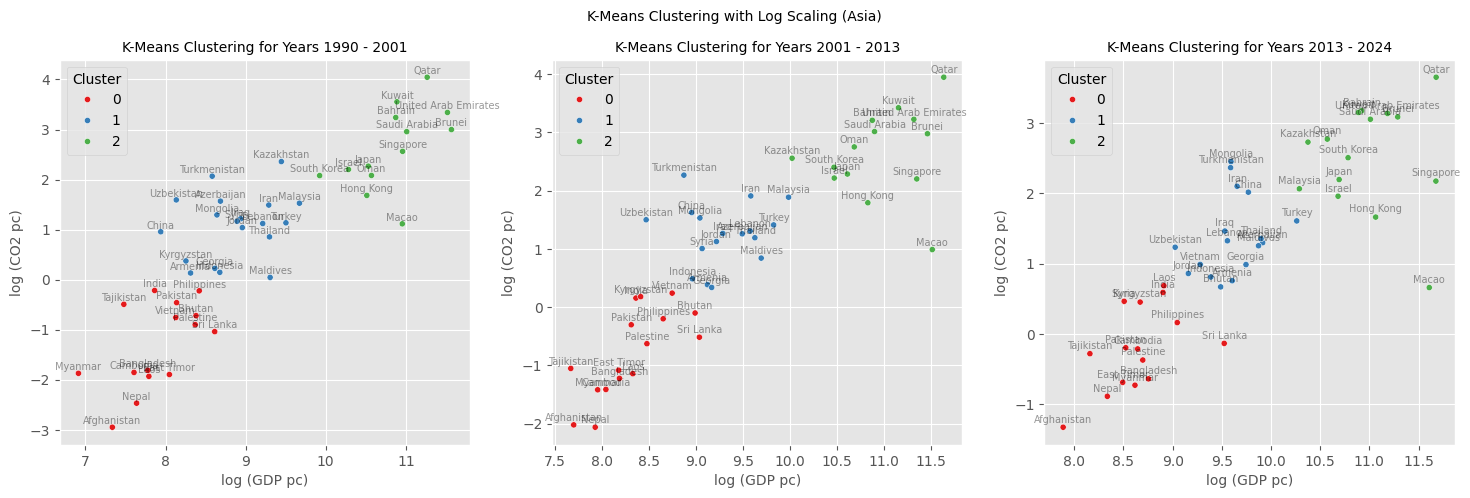

In [42]:
kmeans_cluster_continent('Asia', num_clusters=3)

### North America

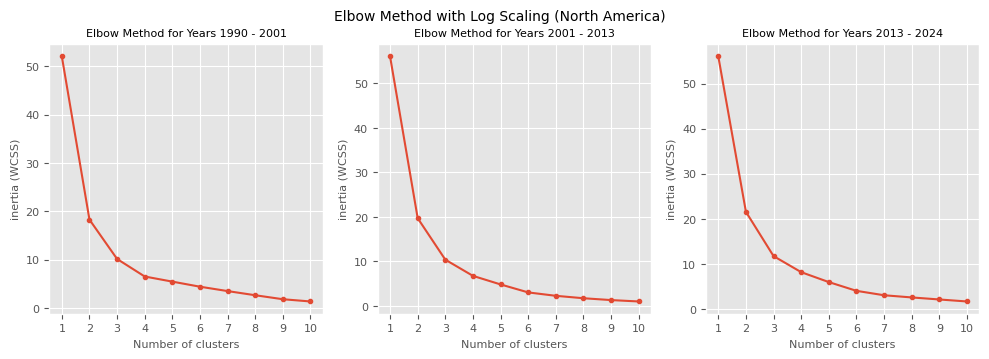

In [30]:
elbow_method_continent('North America')

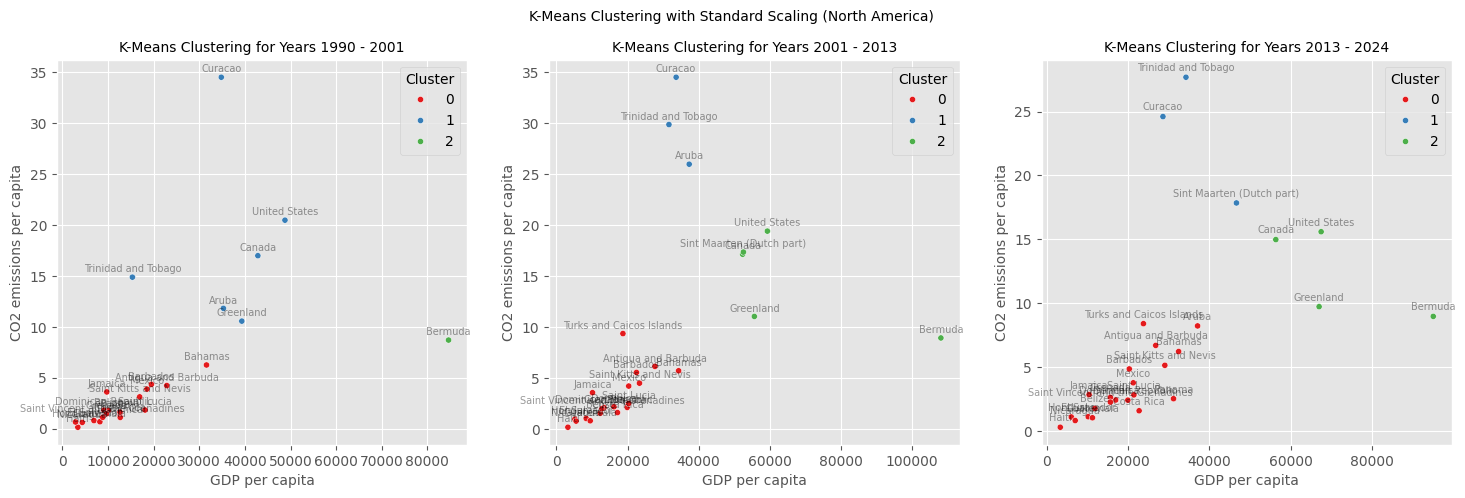

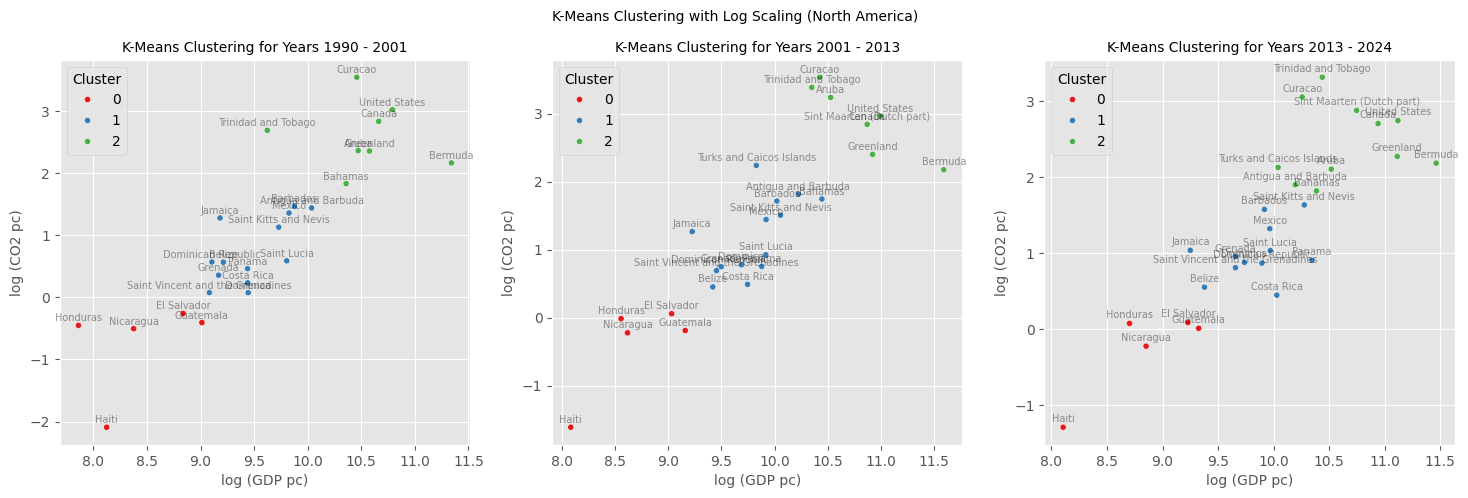

In [43]:
kmeans_cluster_continent('North America', num_clusters=3)

### Africa

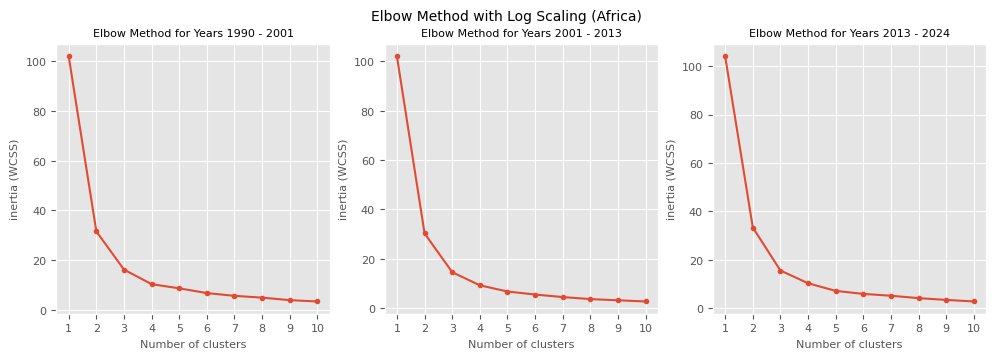

In [32]:
elbow_method_continent('Africa')

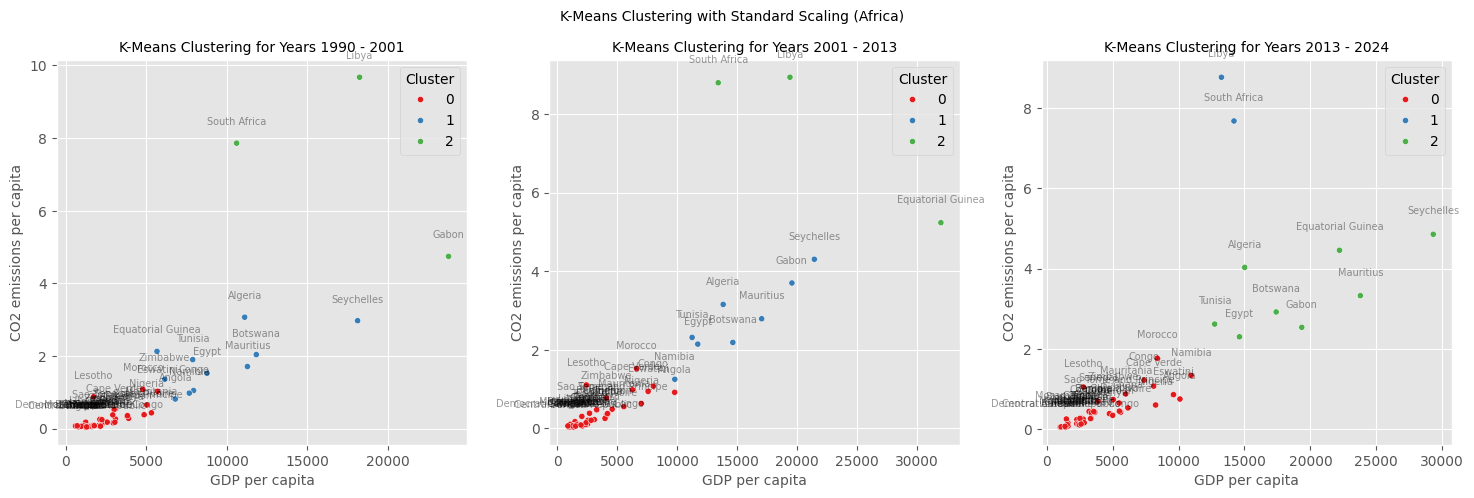

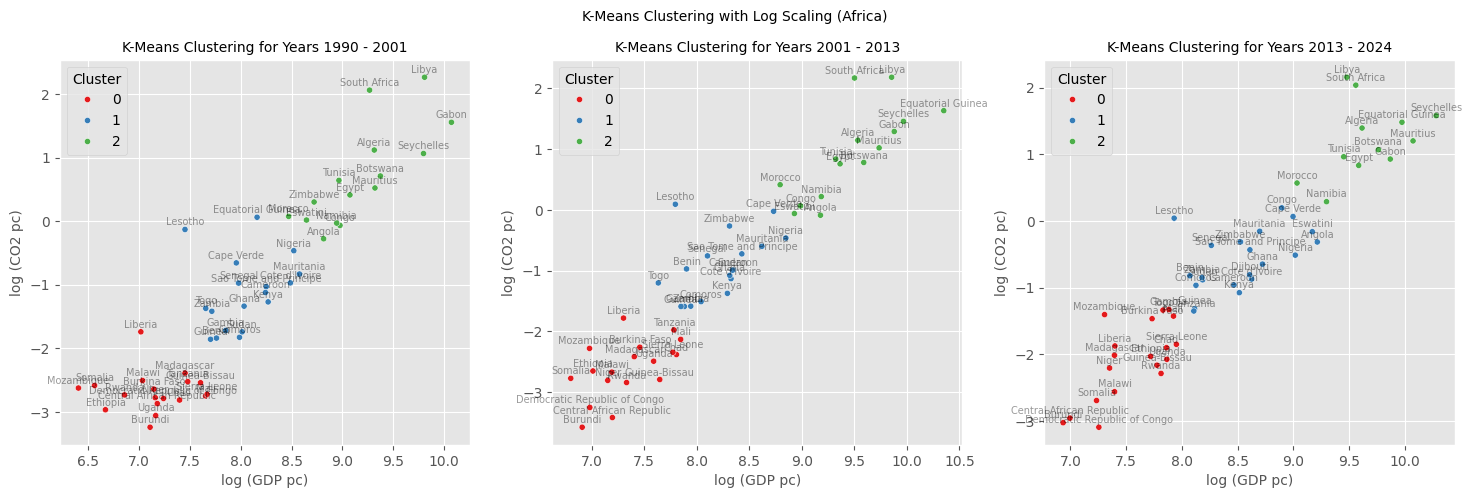

In [44]:
kmeans_cluster_continent('Africa', num_clusters=3)

### Oceania

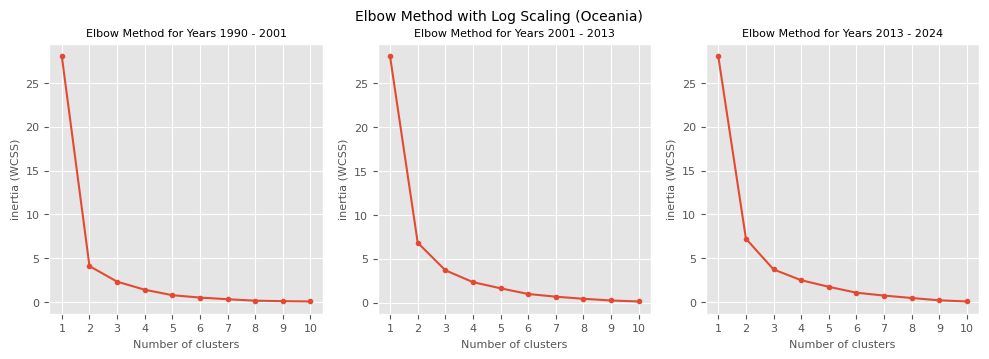

In [ ]:
elbow_method_continent('Oceania')

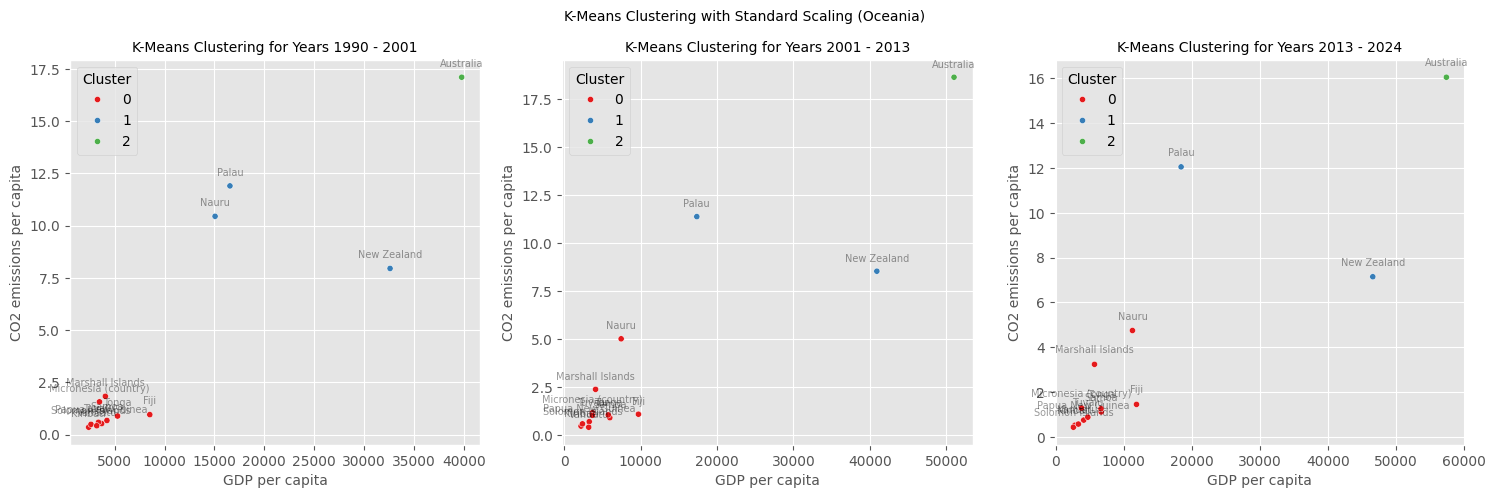

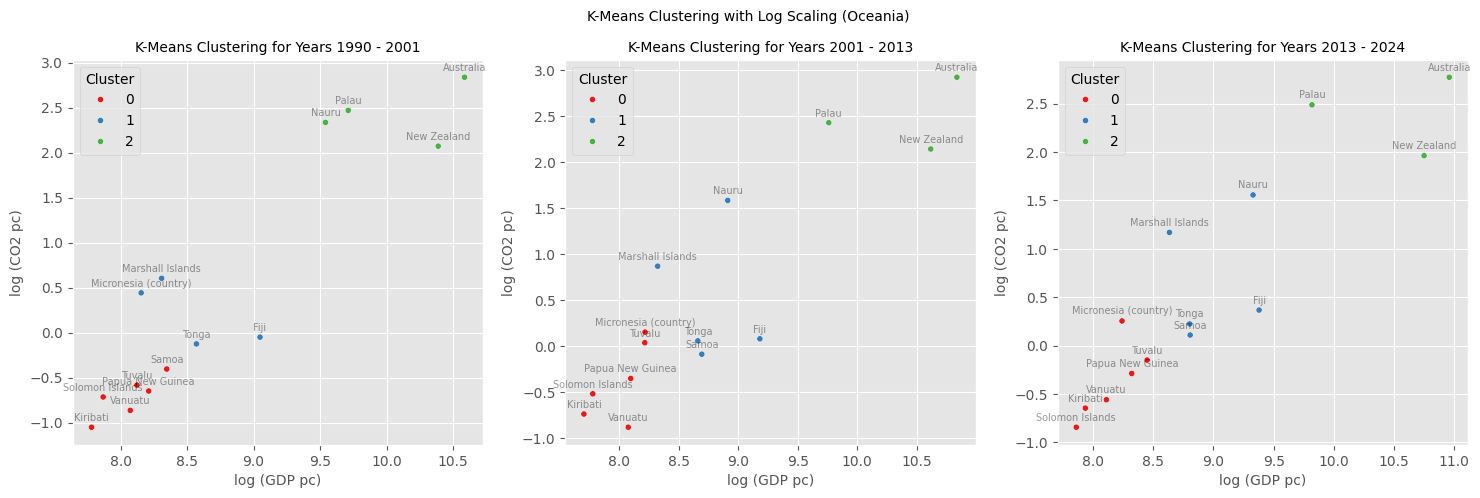

In [45]:
kmeans_cluster_continent('Oceania', num_clusters=3)

### South America

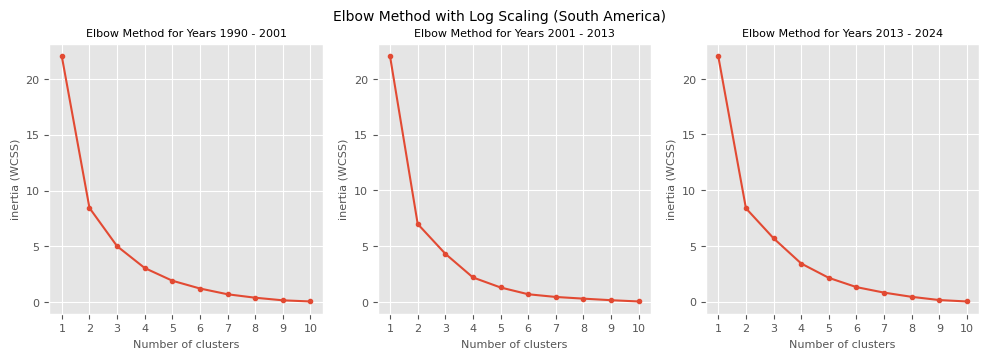

In [36]:
elbow_method_continent('South America')

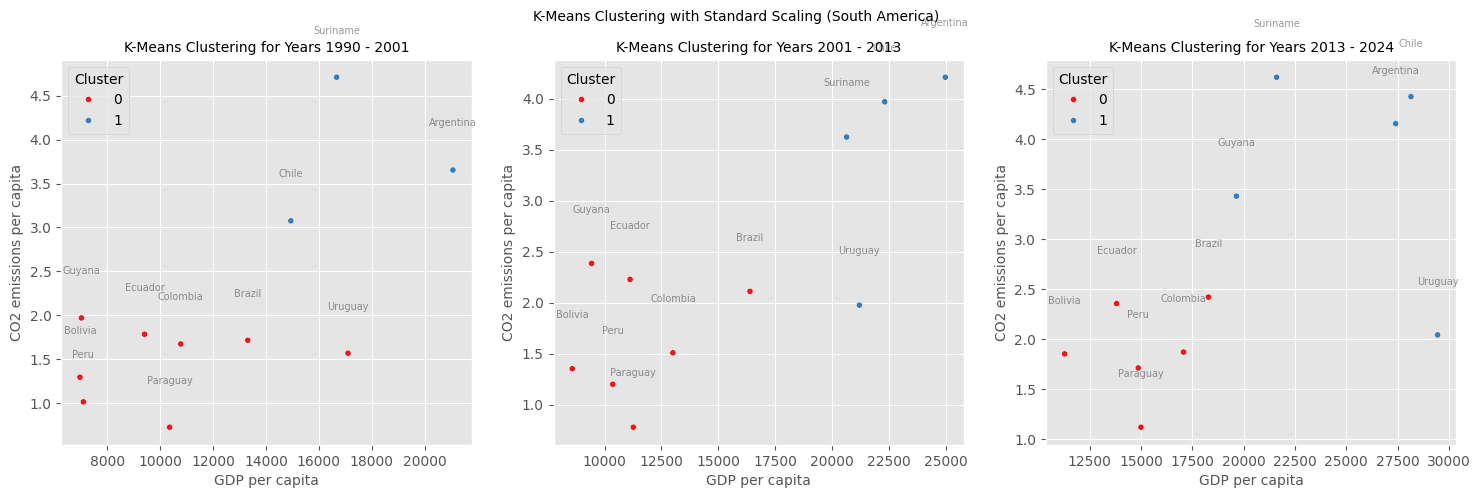

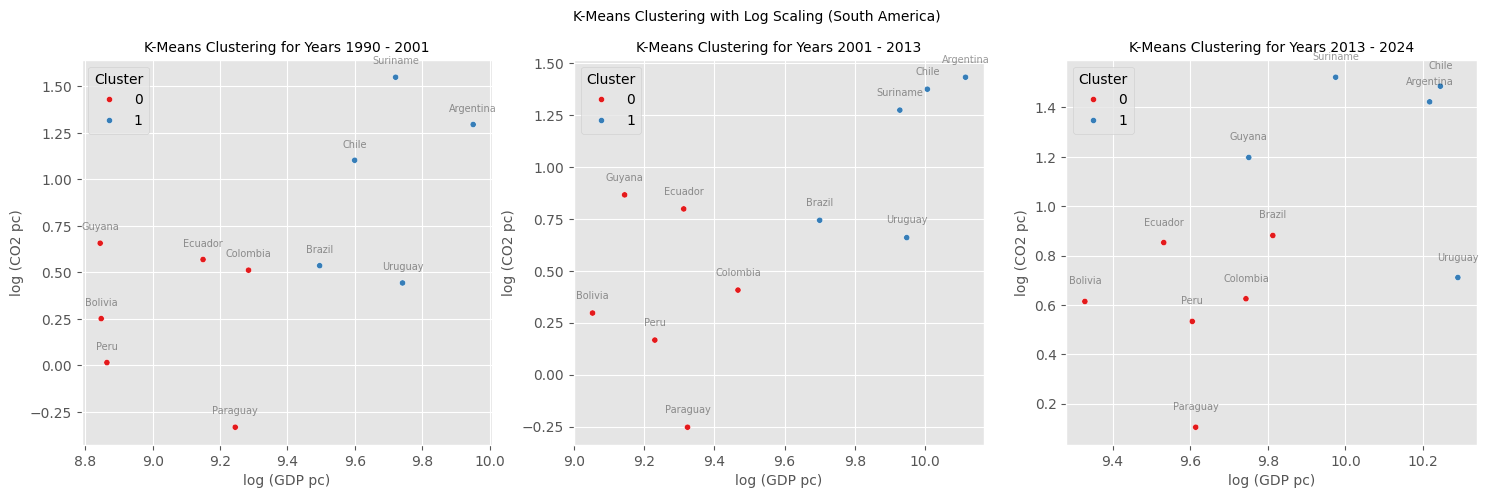

In [46]:
kmeans_cluster_continent('South America', num_clusters=2)